<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 6 - LSTM&GRU 
**Nome:Augusto Cesar de Camargo Neto**

**Numero Usp: 11891023**









______________




O objetivo desta lista é fazer com que vocês treinem um modelo de análise de sentimentos utilizando GRU's e LSTM's. Essa lista é semelhante a lista 03 onde aprendemos a usar embeddings e onde você ja recebeu a arquitetura do seu modelo quase pronta. A diferença é que desta vez você ira construir sozinho sua rede e utilizará as camadas que acabamos de aprender: LSTM e GRU.
 
Essa tambêm será a primeira rede recorrente que montaremos, portanto a tokenização será ligeiramente diferente (por exemplo o padding não é mais necessário.)

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tf.__version__

'2.2.1'

## Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte de 10 mil linhas do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [4]:
#b2wCorpus = pd.read_csv("../Semana 03/data/b2w-10k.csv")
#
# Estou importando a base original da B2W, sem cortes.
b2wCorpus = pd.read_csv("../Semana 03/data/B2W-Reviews01.csv",";")


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
b2wCorpus["review_text"]

0         Estou contente com a compra entrega rápida o ú...
1         Por apenas R$1994.20,eu consegui comprar esse ...
2         SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3         MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4         A entrega foi no prazo, as americanas estão de...
                                ...                        
132368    Vale muito, estou usando no controle do Xbox e...
132369    Prático e barato, super indico o produto para ...
132370    Chegou antes do prazo previsto e corresponde a...
132371    Material fraco, poderia ser melhor. Ficou deve...
132372    Comprei esse produto, quando chegou estava com...
Name: review_text, Length: 132373, dtype: object


## Pré-processamento 
# <font color='blue'>Questão 1 </font>
Copie suas etapas de préprocessamento da lista 03, ou seja, selecione apenas as colunas relevantes ("review_text" e "recommend_to_a_friend"), converta a coluna "review_text" de uma coluna de `str` para uma coluna de `int` e separe os dados em teste e treino.


In [6]:
# Ajuste de Yes/No Para binário (1/0)
b2wCorpus= b2wCorpus[["review_text", "recommend_to_a_friend"]]
b2wCorpus['recommend_to_a_friend'].replace({'No': 0, 'Yes': 1}, inplace = True)
b2wCorpus.head()
b2wCorpus["recommend_to_a_friend"].value_counts()

1.0    96368
0.0    35987
Name: recommend_to_a_friend, dtype: int64

In [7]:
# função para limpeza
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [8]:
# processo de equilibrio de classes, deixo a quantidade de 0s iguais as de 1s
df_neg=b2wCorpus.query('recommend_to_a_friend==0')
df_pos=b2wCorpus.query('recommend_to_a_friend==1')

In [9]:
df_pos= df_pos.head(35987)

In [10]:
df_pos.shape

(35987, 2)

In [11]:
df_pos.review_text = df_pos.review_text.apply(lambda x: preprocess(x))
df_pos.head()

,review_text,recommend_to_a_friend
0,contente compra entrega rapida unico problema ...,1.0
1,apenas r 1994 20 consegui comprar lindo copo a...,1.0
2,supera agilidade praticidade outras panelas el...,1.0
3,filho amou parece verdade tantos detalhes,1.0
4,entrega prazo americanas estao parabens smart ...,1.0


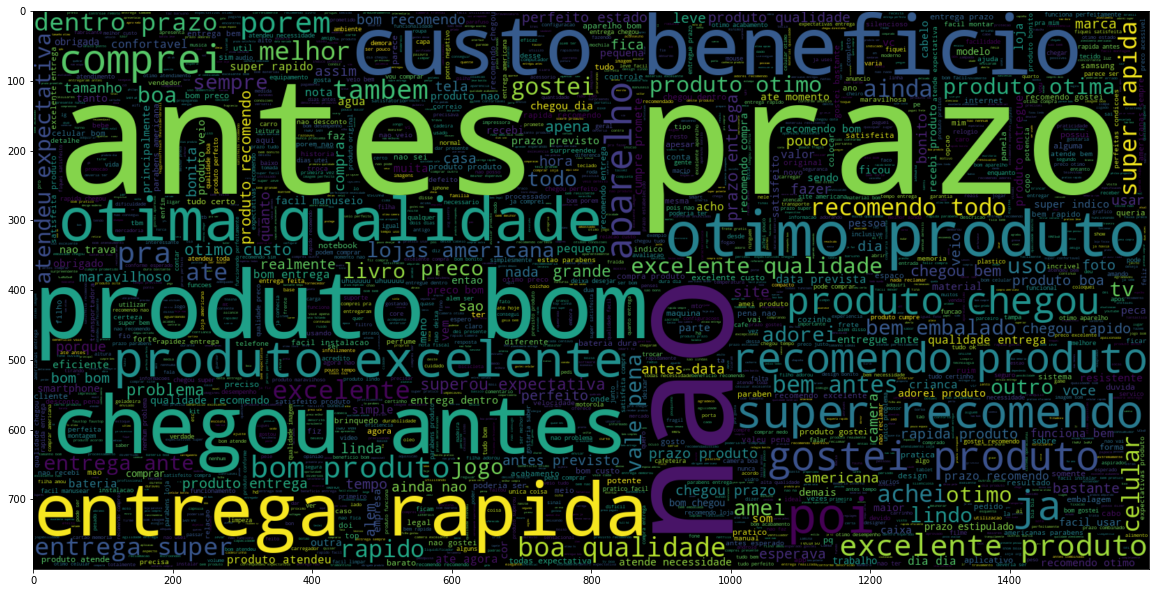

In [12]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_pos[df_pos.recommend_to_a_friend == 1].review_text))
plt.imshow(wc , interpolation = 'bilinear')

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


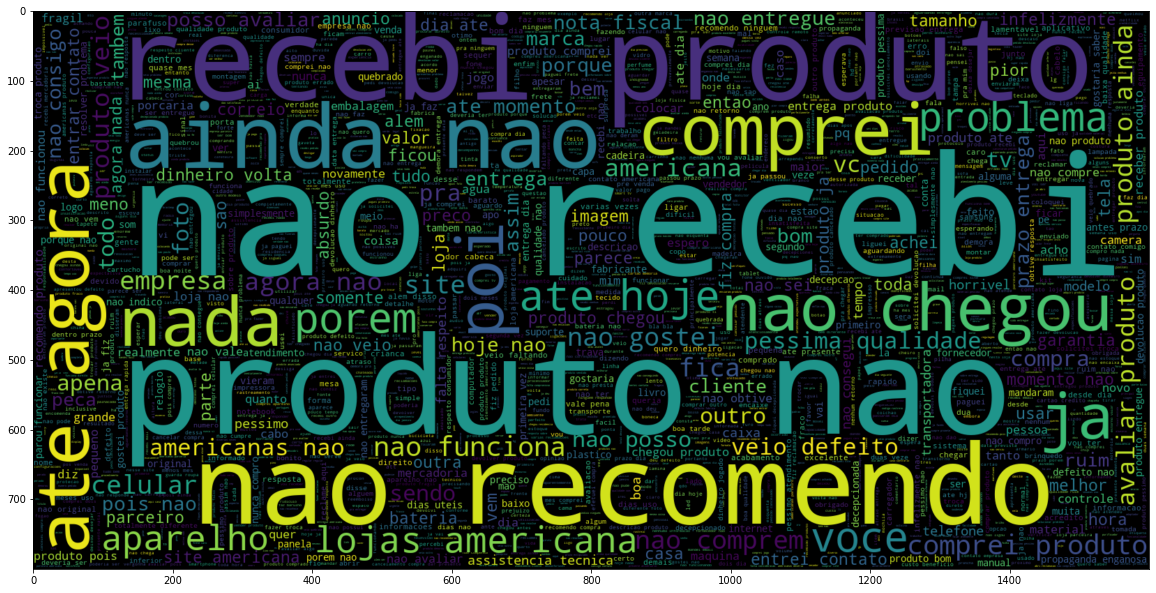

In [13]:
df_neg.head()
from wordcloud import WordCloud
df_neg.review_text = df_neg.review_text.apply(lambda x: preprocess(x))
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_neg[df_neg.recommend_to_a_friend == 0].review_text))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
df=pd.concat([df_neg,df_pos],axis=0)
df.head()

,review_text,recommend_to_a_friend
9,produto nao entregue americanas descontando fa...,0.0
12,jogo panelas excelente material entrega tempo ...,0.0
13,celular nao vale nada bateria nao vale nada de...,0.0
15,mochila nao fechando direito nao recomendo fil...,0.0
25,nao recebi produto americanas sabe disso pois ...,0.0


In [15]:
df["recommend_to_a_friend"].value_counts()

1.0    35987
0.0    35987
Name: recommend_to_a_friend, dtype: int64

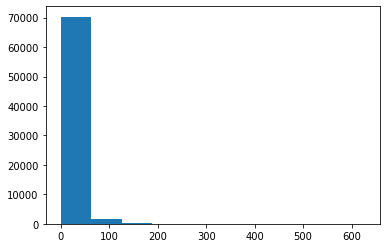

In [16]:
plt.hist([len(linha.split()) for linha in df["review_text"]])
plt.show()

In [17]:
x = df[['review_text']].values
y = df[['recommend_to_a_friend']].values

print(df.recommend_to_a_friend.value_counts()/ df.shape[0])

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

1.0    0.5
0.0    0.5
Name: recommend_to_a_friend, dtype: float64


## Tokenizando




# <font color='blue'>Questão 2 </font>
Utilizando a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) tokenize os inputs.
Declare a camada e então chame a função `adapt()` no seu conjunto de treino para adequar o seu vocabulário aos reviews. 

Note que o uso de padding não é mais necessario.

In [18]:

vectorize_layer = TextVectorization(                                      
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=75
                                        )

vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)

35563


## LSTM&GRU

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

#  <font color='blue'>Questão 3 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas  [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
as
b) Como foi a performance desta rede em comparação a da lista 3?

A rede da lista 3 está "overfitada". A rede LSTM utilizada convergiu com ótimos resultados sem overfit utilizando as instâncias (70k no total) "limpas" e balanceadas.



In [19]:
model = keras.Sequential()
model.add(vectorize_layer)
model.add(keras.layers.Embedding(vocab_size + 2, 64, input_length=75))
model.add(keras.layers.LSTM(16, dropout=0.5, return_sequences=True))
#model.add(keras.layers.LSTM(16, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.LSTM(16, dropout=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1800/1800 [==============================] - 96s 54ms/step - loss: 0.4875 - accuracy: 0.7782 - val_loss: 0.4612 - val_accuracy: 0.8050
Epoch 2/10
1800/1800 [==============================] - 101s 56ms/step - loss: 0.4707 - accuracy: 0.7945 - val_loss: 0.4858 - val_accuracy: 0.7778
Epoch 3/10
1800/1800 [==============================] - 100s 56ms/step - loss: 0.4560 - accuracy: 0.8052 - val_loss: 0.4477 - val_accuracy: 0.8127
Epoch 4/10
1800/1800 [==============================] - 101s 56ms/step - loss: 0.4271 - accuracy: 0.8319 - val_loss: 0.4163 - val_accuracy: 0.8484
Epoch 5/10
1800/1800 [==============================] - 101s 56ms/step - loss: 0.4149 - accuracy: 0.8475 - val_loss: 0.4112 - val_accuracy: 0.8482
Epoch 6/10
1800/1800 [==============================] - 101s 56ms/step - loss: 0.4138 - accuracy: 0.8472 - val_loss: 0.4465 - val_accuracy: 0.8204
Epoch 7/10
1800/1800 [==============================] - 102s 56ms/step - loss: 0.4481 - accuracy: 0.8165 - val_loss: 0.

In [21]:
model.evaluate(x_val, y_val)

450/450 [==============================] - 4s 8ms/step - loss: 0.2808 - accuracy: 0.9013


[0.280760794878006, 0.9012851715087891]

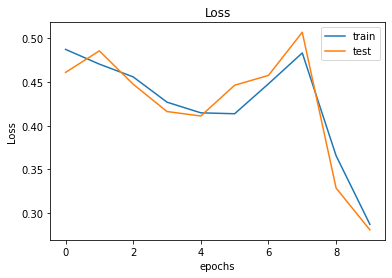

In [22]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

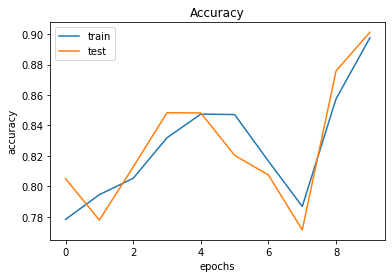

In [23]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [47]:
y_pred = model.predict(["submarino"])
print(np.round(y_pred))

[[0.]]


#  <font color='blue'>Questão 4 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas [GRU](https://keras.io/api/layers/recurrent_layers/gru/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?


A rede da lista 3 está "overfitada". A rede GRU utilizada convergiu com ótimos resultados sem overfit utilizando as instâncias (70k no total) "limpas" e balanceadas.


In [ ]:
model = keras.Sequential()
model.add(vectorize_layer)
model.add(keras.layers.Embedding(vocab_size + 2, 64, input_length=75))
model.add(keras.layers.GRU(16, dropout=0.5, return_sequences=True))
model.add(keras.layers.GRU(16, dropout=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
b2wCorpus.review_text.to_numpy()

array([list([181, 6936, 14, 4, 1664, 2499, 2320, 5, 528, 362, 14, 25, 5437, 15, 26, 4487, 1450, 38, 10355, 8, 902, 5, 2193, 56, 372, 14, 996, 3]),
       list([22, 102, 1272, 3894, '0', 1, 47, 4750, 1815, 143, 5185, 8047, 2, 41805, 3]),
       list([15607, 10, 14911, 6, 46064, 178, 30424, 14150, 3, 22142, 1029, 245, 17806, 11, 51539, 2, 4704, 24, 3848, 23, 1, 36, 1523, 63, 104, 1, '0', '0', 436, 3, 850, 17806, 15, 63, 31, 1395, 1, 2532, '0', 436, 3, 47, 22522, 3]),
       ..., list([428, 131, 8, 566, 1322, 6, 3024, 30, 2825]),
       list([1143, 4916, 1, 494, 39, 153, 3, 366, 4825, 19, 172, 918, 3]),
       list([9735, 143, 902, 1, 67, 428, 135, 14, 20096, 3, 78742, 1, 59, 91, 96, '0', 330, 1, 18, 90, 12967, 5, 902, 6, 188, 5, 149393, 3])],
      dtype=object)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Redes Bi-direcionais
#  <font color='blue'>Questão 5 </font>

a) Defina, compile, treine e avalie um novo modelo que utilize contexto em ambas as direções usando a camada [`Bidirectional()`](https://keras.io/api/layers/recurrent_layers/bidirectional/), seja com camadas GRU ou LSTM.


b) Como foi sua performance em relação as questões anteriores com contexto unidirecional?

A rede bidericional "deu um trampo dos inferno" pra encontrar os valores que não a overfitacem. Os resultados das 3 redes estão praticamente dentro de um mesmo intervalo de desvio padrão.

**<font color='red'> Sua resposta aqui </font>**

In [ ]:
model = keras.Sequential()
model.add(vectorize_layer)
model.add(keras.layers.Embedding(vocab_size + 2, 64, input_length=75))
forward_layer = keras.layers.LSTM(16, return_sequences=True)
backward_layer = keras.layers.LSTM(16, return_sequences=True, go_backwards=True)
model.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.22)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();